# Testing Sigmoid Function by John Houghton

In [1]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def multiplier(x):
    return x * 2

In [2]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.randn(100,1), columns=['random'])
df['sigmoid'] = df['random'].apply(sigmoid)
df['random2'] = df['random'].apply(multiplier)
df['sigmoid2'] = df['random2'].apply(sigmoid)
df.head()

,random,sigmoid,random2,sigmoid2
0,0.097256,0.524295,0.194513,0.548475
1,0.846784,0.699892,1.693568,0.844693
2,1.163813,0.762025,2.327625,0.911139
3,-0.291063,0.427744,-0.582125,0.358444
4,0.082619,0.520643,0.165238,0.541216


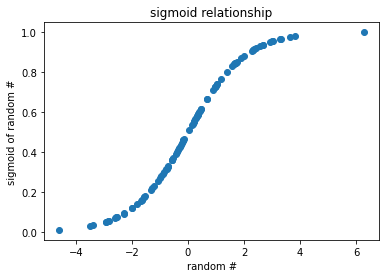

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.scatter(df['random2'], df['sigmoid2'])
plt.title('sigmoid relationship')
plt.ylabel('sigmoid of random #')
plt.xlabel('random #')
plt.show()

In [4]:
# sigmoid calculator
sigmoid(1)

0.7310585786300049

# Predicting sentiment from product reviews


The goal of this first notebook is to explore logistic regression and feature engineering with existing GraphLab functions.

In this notebook you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Use SFrames to do some feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given the logistic regression weights, predictors and ground truth labels, write a function to compute the **accuracy** of the model.
* Inspect the coefficients of the logistic regression model and interpret their meanings.
* Compare multiple logistic regression models.

Let's get started!
    
## Fire up GraphLab Create

Make sure you have the latest version of GraphLab Create.

In [5]:
from __future__ import division
# import graphlab
import turicreate as graphlab
import math
import string

# Data preparation

We will use a dataset consisting of baby product reviews on Amazon.com.

In [6]:
products = graphlab.SFrame('amazon_baby.gl/')

Now, let us see a preview of what the dataset looks like.

In [7]:
products

name,review,rating
Planetwise Flannel Wipes,"These flannel wipes areOK, but in my opinion ...",3.0
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0


## Build the word count vector for each review

Let us explore a specific example of a baby product.


In [8]:
products[269]

{'name': 'The First Years Massaging Action Teether',
 'review': 'A favorite in our house!',
 'rating': 5.0}

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. In this notebook, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](https://www.cis.upenn.edu/~treebank/tokenization.html) for an example of smart handling of punctuations.

In [11]:
def remove_punctuation(text):
    import string
    return text.translate(string.punctuation) 

review_without_punctuation = products['review'].apply(remove_punctuation)
products['word_count'] = graphlab.text_analytics.count_words(review_without_punctuation)

Now, let us explore what the sample example above looks like after these 2 transformations. Here, each entry in the **word_count** column is a dictionary where the key is the word and the value is a count of the number of times the word occurs.

In [12]:
products[269]['word_count']

{'our': 1.0, 'in': 1.0, 'house': 1.0, 'favorite': 1.0, 'a': 1.0}

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [13]:
products = products[products['rating'] != 3]
len(products)

166752

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [14]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products

name,review,rating,word_count,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'recommend': 1.0,'moist': 1.0, 'osocozy': ...",1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'quilt': 1.0,'comfortable': 1.0, ...",1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'tool': 1.0, 'clever':1.0, 'little': 1.0, ...",1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,"{'rock': 1.0, 'many':1.0, 'headaches': 1.0, ...",1
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0,"{'thumb': 1.0, 'or': 1.0,'break': 1.0, 'trying': ...",1
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0,"{'for': 1.0, 'barnes':1.0, 'at': 1.0, 'is': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0,"{'right': 1.0, 'because':1.0, 'questions': 1.0, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0,"{'like': 1.0, 'and': 1.0,'changes': 1.0, 'the': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,"{'in': 1.0, 'pages': 1.0,'out': 1.0, 'run': 1.0, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,"{'tracker': 1.0,'recommend': 1.0, ...",1


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [16]:
train_data, test_data = products.random_split(.8, seed=1)
print(len(train_data))
print(len(test_data))

133416
33336


# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count** as a feature and the column **sentiment** as the target. We will use `validation_set=None` to obtain same results as everyone else.

**Note:** This line may take 1-2 minutes.

In [17]:
sentiment_model = graphlab.logistic_classifier.create(train_data,
                                                      target = 'sentiment',
                                                      features=['word_count'],
                                                      validation_set=None)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133416

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 57445

Number of coefficients      : 57446

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 4        | 0.250000  | 1.610099     | 0.840724          |

| 1         | 9        | 3.250000  | 2.440730     | 0.931642          |

| 2         | 11       | 2.656037  | 2.842522     | 0.938621          |

| 3         | 12       | 2.656037  | 3.102441     | 0.927535          |

| 4         | 14       | 1.341935  | 3.624608     | 0.945441          |

| 9         | 20       | 1.341935  | 5.027039     | 0.977387          |

+-----------+----------+-----------+--------------+-------------------+

In [18]:
sentiment_model

Class                          : LogisticClassifier

Schema
------
Number of coefficients         : 57446
Number of examples             : 133416
Number of classes              : 2
Number of feature columns      : 1
Number of unpacked features    : 57445

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : lbfgs
Solver iterations              : 10
Solver status                  : Completed (Iteration limit reached).
Training time (sec)            : 3.0101

Settings
--------
Log-likelihood                 : 9620.6091

Highest Positive Coefficients
-----------------------------
word_count[arghhhhhh]          : 48.5657
word_count[screencons]         : 32.0635
word_count[pinkjeep]           : 28.0567
word_count[joovys]             : 27.3089
word_count[ozone]              : 27.1083

Lowest Negative Coefficients
----------------------------
word_count[impulsejeep]       

**Aside**. You may get a warning to the effect of "Terminated due to numerical difficulties --- this model may not be ideal". It means that the quality metric (to be covered in Module 3) failed to improve in the last iteration of the run. The difficulty arises as the sentiment model puts too much weight on extremely rare words. A way to rectify this is to apply regularization, to be covered in Module 4. Regularization lessens the effect of extremely rare words. For the purpose of this assignment, however, please proceed with the model above.

Now that we have fitted the model, we can extract the weights (coefficients) as an SFrame as follows:

In [19]:
weights = sentiment_model.coefficients
weights.column_names()

['name', 'index', 'class', 'value', 'stderr']

In [20]:
weights.head(3)

name,index,class,value,stderr
(intercept),None,1,1.2357054152277833,None
word_count,recommend,1,0.3548384562846558,None
word_count,moist,1,1.0065747450272295,None


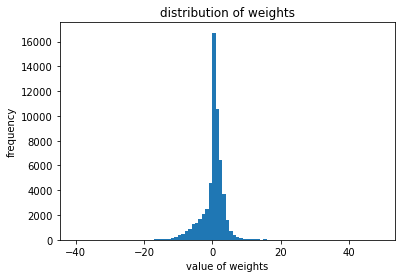

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.hist(weights['value'], bins=np.arange(weights['value'].min(), weights['value'].max()+1))
# fig = plt.scatter(weights['value'], df['sigmoid2'])
plt.title('distribution of weights')
plt.ylabel('frequency')
plt.xlabel('value of weights')
plt.show()

# Quiz Question 1 :
## How many weights are greater than or equal to 0?

There are a total of `121713` coefficients in the model. Recall from the lecture that positive weights $w_j$ correspond to weights that cause positive sentiment, while negative weights correspond to negative sentiment. 

Fill in the following block of code to calculate how many *weights* are positive ( >= 0). (**Hint**: The `'value'` column in SFrame *weights* must be positive ( >= 0)).

In [23]:
# example filter >> sf[(sf['id'] >= 1) & (sf['id'] <= 2)]

num_positive_weights = weights[(weights['value'] > 0)].num_rows()
num_negative_weights = weights[(weights['value'] < 0)].num_rows()

print("Number of positive weights: %s " % num_positive_weights)
print("Number of negative weights: %s " % num_negative_weights)

Number of positive weights: 40270 
Number of negative weights: 17176 


**Quiz Question:** How many weights are >= 0?

## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **test data**. In this section, we will explore this in the context of 3 examples in the test dataset.  We refer to this set of 3 examples as the **sample_test_data**.

In [25]:
sample_test_data = test_data[10:13]
print(sample_test_data['rating'])
sample_test_data

[5.0, 2.0, 1.0]


name,review,rating,word_count,sentiment
Our Baby Girl Memory Book,Absolutely love it andall of the Scripture in ...,5.0,"{'again': 1.0, 'book':1.0, 'same': 1.0, ...",1
Wall Decor RemovableDecal Sticker - Colorful ...,Would not purchase againor recommend. The decals ...,2.0,"{'peeling': 1.0, '5':1.0, 'about': 1.0, 'f ...",-1
New Style Trailing CherryBlossom Tree Decal ...,Was so excited to getthis product for my baby ...,1.0,"{'on': 1.0, 'waste': 1.0,'wall': 1.0, ...",-1


Let's dig deeper into the first row of the **sample_test_data**. Here's the full review:

In [26]:
sample_test_data[0]['review']

'Absolutely love it and all of the Scripture in it.  I purchased the Baby Boy version for my grandson when he was born and my daughter-in-law was thrilled to receive the same book again.'

That review seems pretty positive.

Now, let's see what the next row of the **sample_test_data** looks like. As we could guess from the sentiment (-1), the review is quite negative.

In [27]:
sample_test_data[1]['review']

'Would not purchase again or recommend. The decals were thick almost plastic like and were coming off the wall as I was applying them! The would NOT stick! Literally stayed stuck for about 5 minutes then started peeling off.'

In [28]:
sample_test_data[2]['review']

"Was so excited to get this product for my baby girls bedroom!  When I got it the back is NOT STICKY at all!  Every time I walked into the bedroom I was picking up pieces off of the floor!  Very very frustrating!  Ended up having to super glue it to the wall...very disappointing.  I wouldn't waste the time or money on it."

We will now make a **class** prediction for the **sample_test_data**. The `sentiment_model` should predict **+1** if the sentiment is positive and **-1** if the sentiment is negative. Recall from the lecture that the **score** (sometimes called **margin**) for the logistic regression model  is defined as:

$$
\mbox{score}_i = \mathbf{w}^T h(\mathbf{x}_i)
$$ 

where $h(\mathbf{x}_i)$ represents the features for example $i$.  We will write some code to obtain the **scores** using GraphLab Create. For each row, the **score** (or margin) is a number in the range **[-inf, inf]**.

In [30]:
scores = sentiment_model.predict(sample_test_data, output_type='margin')
print(scores)

[6.59332853280192, -5.387775160150986, -14.785613267963893]


### Predicting sentiment

These scores can be used to make class predictions as follows:

$$
\hat{y} = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{w}^T h(\mathbf{x}_i) > 0 \\
      -1 & \mathbf{w}^T h(\mathbf{x}_i) \leq 0 \\
\end{array} 
\right.
$$

Using scores, write code to calculate $\hat{y}$, the class predictions:

In [31]:
def make_predictions(scores):
    predictions = []
    i = 0
    while i < len(scores):
        if scores[i] > 0:
            predictions.append(1)
        else:
            predictions.append(-1)
        i += 1
    print(predictions)

In [32]:
make_predictions(scores)

[1, -1, -1]


Run the following code to verify that the class predictions obtained by your calculations are the same as that obtained from GraphLab Create.

In [35]:
print("Class predictions according to GraphLab Create:")
print(sentiment_model.predict(sample_test_data))

Class predictions according to GraphLab Create:
[1, -1, -1]


**Checkpoint**: Make sure your class predictions match with the one obtained from GraphLab Create.

### Probability predictions

Recall from the lectures that we can also calculate the probability predictions from the scores using:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))}.
$$

Using the variable **scores** calculated previously, write code to calculate the probability that a sentiment is positive using the above formula. For each row, the probabilities should be a number in the range **[0, 1]**.

In [36]:
def linear_predictions(scores):
    predictions = []
    i = 0
    while i < len(scores):
        prediction = 1 / (1 + math.exp(-scores[i]))
        predictions.append(prediction)
        i += 1
    print(predictions)

In [37]:
linear_predictions(scores)

[0.9986323988645607, 0.004551325025627894, 3.7904396080979145e-07]


**Checkpoint**: Make sure your probability predictions match the ones obtained from GraphLab Create.

In [39]:
print("Class predictions according to GraphLab Create:")
print(sentiment_model.predict(sample_test_data, output_type='probability'))

Class predictions according to GraphLab Create:
[0.9986323988645608, 0.004551325025627895, 3.7904396080979177e-07]


** Quiz Question:** Of the three data points in **sample_test_data**, which one (first, second, or third) has the **lowest probability** of being classified as a positive review?

# Find the most positive (and negative) review

We now turn to examining the full test dataset, **test_data**, and use GraphLab Create to form predictions on all of the test data points for faster performance.

Using the `sentiment_model`, find the 20 reviews in the entire **test_data** with the **highest probability** of being classified as a **positive review**. We refer to these as the "most positive reviews."

To calculate these top-20 reviews, use the following steps:
1.  Make probability predictions on **test_data** using the `sentiment_model`. (**Hint:** When you call `.predict` to make predictions on the test data, use option `output_type='probability'` to output the probability rather than just the most likely class.)
2.  Sort the data according to those predictions and pick the top 20. (**Hint:** You can use the `.topk` method on an SFrame to find the top k rows sorted according to the value of a specified column.)

In [40]:
test_data['prediction'] = sentiment_model.predict(test_data, output_type='probability')

In [41]:
top_20 = test_data.topk('prediction', k=20)
top_20.head(5)

name,review,rating,word_count,sentiment,prediction
Basic Comfort Handy'sPlus Pad Full ...,While my 4 yr old hadbeen potty trained since ...,5.0,"{'wetting': 1.0, 'bed':1.0, 'dealing': 1.0, ...",1,1.0
Munchkin Mozart MagicCube ...,My wife and I have beenliving with these 8 t ...,4.0,"{'way': 1.0, 'about':1.0, 'feels': 1.0, 'h ...",1,1.0
BABYBJORN Potty Chair -Red ...,Our family is juststarting EC (elimination ...,5.0,"{'boys': 1.0, 'directed':1.0, 'size': 1.0, 'su ...",1,1.0
Summer Infant CompleteNursery Care Kit ...,This Nursery and BathCare Set contains a ...,4.0,"{'years': 1.0,'contents': 1.0, ...",1,1.0
Peg Perego Primo ViaggioCar Seat / Infant Car ...,We have been using thisseat for a year now ( ...,5.0,"{'product': 1.0,'helped': 1.0, 'hope': ...",1,1.0


In [46]:
from turicreate import aggregate as agg
most_positive = top_20.groupby('name'
               , operations={
                'counts': agg.COUNT() 
                , 'avg_prediction': agg.MEAN('prediction')
                            }
              )

In [47]:
# get products with highest counts in top 20
most_positive = most_positive.sort('counts', ascending=False)
most_positive.head(3)

name,counts,avg_prediction
"Itzbeen Pocket Nanny BabyCare Timer, Blue ...",3,1.0
"Moby Wrap Original 100%Cotton Baby Carrier, Red ...",2,1.0
"Stork Craft BeatriceCombo Tower Chest, White ...",1,1.0


## Question 2: Which of the following products are represented in the 20 most positive reviews?

In [48]:
options = ['Snuza Portable Baby Movement Monitor'
          , 'MamaDoo Kids Foldable Play Yard Mattress Topper, Blue'
          , 'Britax Decathlon Convertible Car Seat, Tiffany'
          , 'Safety 1st Exchangeable Tip 3 in 1 Thermometer']

In [247]:
most_positive.filter_by(options, 'name')

name,counts,avg_prediction
"Britax DecathlonConvertible Car Seat, ...",1,1.0


answer = Britax Decathlon Convertible Car Seat, Tiffany

**Quiz Question**: Which of the following products are represented in the 20 most positive reviews? [multiple choice]

## Quiz Question 3
Now, let us repeat this exercise to find the "most negative reviews." Use the prediction probabilities to find the  20 reviews in the **test_data** with the **lowest probability** of being classified as a **positive review**. Repeat the same steps above but make sure you **sort in the opposite order**.

In [50]:
bottom_20 = test_data.topk('prediction', k=20, reverse = True)

from turicreate import aggregate as agg
most_negative = bottom_20.groupby('name'
               , operations={
                'counts': agg.COUNT()
                , 'avg_prediction': agg.MEAN('prediction')
                            }
              )

In [51]:
options = ['The First Years True Choice P400 Premium Digital Monitor, 2 Parent Unit'
           ,'JP Lizzy Chocolate Ice Classic Tote Set'
           ,'Peg-Perego Tatamia High Chair, White Latte'
           ,'Safety 1st High-Def Digital Monitor']

In [52]:
most_negative.filter_by(options, 'name')

name,counts,avg_prediction
"Peg-Perego Tatamia HighChair, White Latte ...",1,1.4384654956017865e-18
Safety 1st High-DefDigital Monitor ...,1,1.3183706631240906e-23
The First Years TrueChoice P400 Premium ...,1,9.039884958242737e-38


**Quiz Question**: Which of the following products are represented in the 20 most negative reviews?  [multiple choice]

## Compute accuracy of the classifier

We will now evaluate the accuracy of the trained classifier. Recall that the accuracy is given by


$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

This can be computed as follows:

* **Step 1:** Use the trained model to compute class predictions (**Hint:** Use the `predict` method)
* **Step 2:** Count the number of data points when the predicted class labels match the ground truth labels (called `true_labels` below).
* **Step 3:** Divide the total number of correct predictions by the total number of data points in the dataset.

Complete the function below to compute the classification accuracy:

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.hist(test_data['score'], bins=np.arange(test_data['score'].min(), test_data['score'].max()+1))
# fig = plt.hist(test_data['predictions'], bins=np.arange(test_data['predictions'].min(), test_data['predictions'].max()+1))
# fig = plt.scatter(test_data['prediction'], test_data['sentiment'])
plt.title('distribution of weights')
plt.ylabel('frequency')
plt.xlabel('value of weights')
plt.show()

RuntimeError: Column name score does not exist.

In [374]:
# def get_classification_accuracy(model, data, true_labels):
def get_classification_accuracy(model = sentiment_model, data = train_data, true_labels = train_data['sentiment']):

    # First get the predictions
    data['score'] = model.predict(data, output_type='margin')
    data['prediction'] = data['score'].apply(lambda x: 1 if x > 0 else -1)

    # Compute the number of correctly classified examples
    num_correct = 0
    i = 0
    while i < len(data):
        if data['prediction'][i] == data['sentiment'][i]:
            num_correct += 1
        else:
            num_correct += 0 
        i += 1

    # Then compute accuracy by dividing num_correct by total number of examples
    accuracy = ( num_correct / data.num_rows() ) 
    
    return accuracy

Now, let's compute the classification accuracy of the **sentiment_model** on the **test_data**.

In [362]:
get_classification_accuracy()

0.979440247046831

**Quiz Question**: What is the accuracy of the **sentiment_model** on the **test_data**? Round your answer to 2 decimal places (e.g. 0.76).

**Quiz Question**: Does a higher accuracy value on the **training_data** always imply that the classifier is better?

## Learn another classifier with fewer words

There were a lot of words in the model we trained above. We will now train a simpler logistic regression model using only a subset of words that occur in the reviews. For this assignment, we selected a 20 words to work with. These are:

In [363]:
significant_words = ['love', 'great', 'easy', 'old', 'little', 'perfect', 'loves', 
      'well', 'able', 'car', 'broke', 'less', 'even', 'waste', 'disappointed', 
      'work', 'product', 'money', 'would', 'return']

In [364]:
len(significant_words)

20

For each review, we will use the **word_count** column and trim out all words that are **not** in the **significant_words** list above. We will use the [SArray dictionary trim by keys functionality]( https://dato.com/products/create/docs/generated/graphlab.SArray.dict_trim_by_keys.html). Note that we are performing this on both the training and test set.

In [365]:
train_data['word_count_subset'] = train_data['word_count'].dict_trim_by_keys(significant_words, exclude=False)
test_data['word_count_subset'] = test_data['word_count'].dict_trim_by_keys(significant_words, exclude=False)

Let's see what the first example of the dataset looks like:

In [366]:
train_data[0]['review']

'it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.'

The **word_count** column had been working with before looks like the following:

In [367]:
print train_data[0]['word_count']

{'and': 3, 'love': 1, 'it': 3, 'highly': 1, 'osocozy': 1, 'bags': 1, 'holder': 1, 'leak': 1, 'moist': 1, 'does': 1, 'recommend': 1, 'was': 1, 'wipes': 1, 'early': 1, 'not': 2, 'now': 1, 'disappointed': 1, 'wipe': 1, 'keps': 1, 'wise': 1, 'i': 1, 'planet': 1, 'my': 2, 'came': 1}


Since we are only working with a subset of these words, the column **word_count_subset** is a subset of the above dictionary. In this example, only 2 `significant words` are present in this review.

In [368]:
print train_data[0]['word_count_subset']

{'love': 1, 'disappointed': 1}


## Train a logistic regression model on a subset of data

We will now build a classifier with **word_count_subset** as the feature and **sentiment** as the target. 

In [372]:
simple_model = graphlab.logistic_classifier.create(train_data,
                                                   target = 'sentiment',
                                                   features=['word_count_subset'],
                                                   validation_set=None)
simple_model

Logistic regression:

--------------------------------------------------------

Number of examples          : 133416

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 20

Number of coefficients    : 21

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy |

+-----------+----------+--------------+-------------------+

| 1         | 2        | 0.145112     | 0.862917          |

| 2         | 3        | 0.230839     | 0.865713          |

| 3         | 4        | 0.332329     | 0.866478          |

| 4         | 5        | 0.442404     | 0.866748          |

| 5         | 6        | 0.535375     | 0.866815          |

| 6         | 7        | 0.629474     | 0.866815          |

+-----------+----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Class                          : LogisticClassifier

Schema
------
Number of coefficients         : 21
Number of examples             : 133416
Number of classes              : 2
Number of feature columns      : 1
Number of unpacked features    : 20

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 0.01

Training Summary
----------------
Solver                         : newton
Solver iterations              : 6
Solver status                  : SUCCESS: Optimal solution found.
Training time (sec)            : 0.6471

Settings
--------
Log-likelihood                 : 44323.7254

Highest Positive Coefficients
-----------------------------
word_count_subset[loves]       : 1.6773
word_count_subset[perfect]     : 1.5145
word_count_subset[love]        : 1.3654
(intercept)                    : 1.2995
word_count_subset[easy]        : 1.1937

Lowest Negative Coefficients
----------------------------
word_count_subset[disappointed] : -2.3551
wo

In [375]:
simple_model.show()

Canvas is updated and available in a tab in the default browser.


In [397]:
sentiment_model.show()

Canvas is updated and available in a tab in the default browser.


We can compute the classification accuracy using the `get_classification_accuracy` function you implemented earlier.

In [376]:
get_classification_accuracy(simple_model, test_data, test_data['sentiment'])

0.8693004559635229

Now, we will inspect the weights (coefficients) of the **simple_model**:

**Quiz Question**: Consider the coefficients of **simple_model**. There should be 21 of them, an intercept term + one for each word in **significant_words**. How many of the 20 coefficients (corresponding to the 20 **significant_words** and *excluding the intercept term*) are positive for the `simple_model`?

In [379]:
# simple_model.coefficients
simple_model.coefficients[(simple_model.coefficients['value'] > 0)].num_rows()

11

In [389]:
simple_positives = simple_model.coefficients[(simple_model.coefficients['value'] > 0)]['index']
len(simple_positives)

11

In [385]:
sentiment_model.coefficients[(sentiment_model.coefficients['value'] > 0)].num_rows()

68419

In [386]:
sentiment_model.coefficients.num_rows()

121713

In [390]:
sentiment_positives = sentiment_model.coefficients[(sentiment_model.coefficients['value'] > 0)]['index']
len(sentiment_positives)

68419

In [396]:
# compare the 2 sets of positive sentiments to confirm that all positive coefficients in simple_model and also in sentiment_model

sentiment_positives.is_in(simple_positives).sum()

11

In [393]:
type(sentiment_positives)

graphlab.data_structures.sarray.SArray

Let's sort the coefficients (in descending order) by the **value** to obtain the coefficients with the most positive effect on the sentiment.

In [378]:
simple_model.coefficients.sort('value', ascending=False).print_rows(num_rows=21)

+-------------------+--------------+-------+-----------------+-----------------+
|        name       |    index     | class |      value      |      stderr     |
+-------------------+--------------+-------+-----------------+-----------------+
| word_count_subset |    loves     |   1   |  1.67727145556  | 0.0482328275384 |
| word_count_subset |   perfect    |   1   |  1.51448626703  |  0.049861952294 |
| word_count_subset |     love     |   1   |  1.36543549368  | 0.0303546295109 |
|    (intercept)    |     None     |   1   |   1.2995449552  | 0.0120888541331 |
| word_count_subset |     easy     |   1   |  1.19366189833  |  0.029288869202 |
| word_count_subset |    great     |   1   |  0.94469126948  | 0.0209509926591 |
| word_count_subset |    little    |   1   |  0.520628636025 | 0.0214691475665 |
| word_count_subset |     well     |   1   |  0.504256746398 |  0.021381300631 |
| word_count_subset |     able     |   1   |  0.191438302295 | 0.0337581955697 |
| word_count_subset |     ol

**Quiz Question**: Are the positive words in the **simple_model** (let us call them `positive_significant_words`) also positive words in the **sentiment_model**?

# Comparing models

We will now compare the accuracy of the **sentiment_model** and the **simple_model** using the `get_classification_accuracy` method you implemented above.

First, compute the classification accuracy of the **sentiment_model** on the **train_data**:

Now, compute the classification accuracy of the **simple_model** on the **train_data**:

**Quiz Question**: Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TRAINING set?

Now, we will repeat this exercise on the **test_data**. Start by computing the classification accuracy of the **sentiment_model** on the **test_data**:

Next, we will compute the classification accuracy of the **simple_model** on the **test_data**:

**Quiz Question**: Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TEST set?

## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. At the very least, you should healthily beat the majority class classifier, otherwise, the model is (usually) pointless.

What is the majority class in the **train_data**?

In [402]:
num_positive  = (train_data['sentiment'] == +1).sum()
num_negative = (train_data['sentiment'] == -1).sum()
print num_positive
print num_negative

112164
21252


Now compute the accuracy of the majority class classifier on **test_data**.

**Quiz Question**: Enter the accuracy of the majority class classifier model on the **test_data**. Round your answer to two decimal places (e.g. 0.76).

In [403]:
# majority class classifier
num_positive / len(train_data)

0.8407087605684476

**Quiz Question**: Is the **sentiment_model** definitely better than the majority class classifier (the baseline)?